---
title: Flood areas in Saarland
subtitle: Visualizing Generalized Flood Areas for HQ100 Event and relate to an existing flooding event.
authors:
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
date: 2025-05-14
keywords : flooding
---

```{image} https://www.en.urbandataplatform.hamburg/resource/crblob/797502/9c2f2d2edc1149673134bf88ece1dda5/logo-udp-data.jpg
:alt: Urban Data Portal Logo
:width: 250px
:align: center
```

(introduction)=
# Introduction

## Flood areas in Saarland

Saarland, located in southwestern Germany, is particularly vulnerable to flooding due to its dense river network and hilly terrain. Periodic heavy rainfall and overflowing rivers like the Saar and Blies can lead to widespread inundation, especially in low-lying urban and industrial zones. The HQ100 flood areas represent regions statistically likely to flood once every 100 years, serving as critical indicators for urban planning, risk management, and environmental protection. Mapping these zones is essential for identifying vulnerable communities and infrastructure, including industrial facilities that may pose additional environmental risks during extreme flood events.


## Purpose

### Visualizing Generalized Flood Areas and Environmental Risk Sites in Saarland

This Jupyter notebook provides an interactive visualization of the **generalized flood areas (Area100_generalized)** associated with a **100-year flood event (HQ100)** in Saarland. It integrates spatial data from the **Hamburg Urban Data Portal** and the **Geoportal Saarland**, as well as the geolocation of a Wikimedia Commons photo illustrating flood conditions.

#### 🌊 About the HQ100 Flood Area Dataset

- **Event type**: HQ100 (statistical 100-year flood)
- **Layer**: Area100_generalized
- **Data source**: Hamburg Urban Data Portal
- **Coordinate system**: WGS84 (EPSG:4326)
- **Date**: 01.06.2018
- **Coverage**:  
  - **SW corner**: 6.31°E, 49.1°N  
  - **NE corner**: 7.41°E, 49.64°N

This dataset shows flood-prone areas and is useful for planning, disaster risk assessment, and climate adaptation studies.

#### 🏭 IED (IVU) Facilities in Flood-Prone Zones

We additionally integrate data from the **Geoportal Saarland** on **IED-regulated industrial facilities** that could pose environmental risks during floods. These facilities are categorized under the EU’s **IVU (Integrated Pollution Prevention and Control) directive**, which mandates special precautions for pollution control.

- **Dataset**: Hochwasserrisiko – IED-Betriebe des Saarlandes
- **Attributes**:
  - `GEWAESSER`: River name
  - `BETRIEB`: Facility name
  - `GEMEINDE`, `GEMARKUNG`: Municipality & land registry info
  - `GEWKZ`: River code
- **Coordinate system**: WGS84
- **Timeliness**:
  - Created: 10.07.2012
  - Last updated: 01.06.2018
- **Download options**:
  - [WFS](https://geoportal.saarland.de/arcgis/services/Internet/Hochwasser_WFS/MapServer/WFSServer?&request=GetCapabilities&VERSION=1.1.0&SERVICE=WFS)
  - [Shapefile ZIP](https://www.shop.lvgl.saarland.de/cloud/index.php/s/GDZ_Hochwasser/download?path=IED-Anlagen)

**License**: Creative Commons Attribution 4.0 International (CC BY 4.0)  
**Attribution**: © GDI-SL (2018)  
**Contact**: poststelle@umwelt.saarland.de

#### 📸 Image Location Reference

A geotagged image from Wikimedia Commons showing flood impact is added for visual context. This demonstrates how photo evidence can complement official geospatial data in public awareness or participatory science initiatives.


(overview)=
:::{hint} Overview
Questions

What data from the Hamburg and Saarland Urban Data Portals are we visualizing?

How can the visualization of flood zones and industrial facilities support flood risk assessment?

Objectives

Load and map HQ100 generalized flood zones and IED-regulated facilities.

Analyze spatial relationships between flood-prone areas, industrial sites, and citizen-reported observations (e.g., photos).
:::

(requirements)=
## Requirements
Start installing and importing the necessary libraries
### Install Python Packages

In [1]:
pip install geopandas matplotlib pillow

Note: you may need to restart the kernel to use updated packages.


(setup)=
### Import Python Packages

In [2]:
import os
import requests
import geopandas as gpd
import json
from io import BytesIO
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from jupytergis import GISDocument

(functions)=
### Define functions

In [3]:
def get_data_from_wfs(wfs_url, params): 
    try:
        # Fetch data
        r = requests.get(wfs_url, params=params)
        r.raise_for_status()  # Check for HTTP errors
        
        # Read GML directly into GeoDataFrame
        gml_data = BytesIO(r.content)
        data = gpd.read_file(gml_data, driver="GML")
        return data
        
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except Exception as e:
        print(f"Failed to parse GML: {e}")

In [4]:
def get_image_metadata(filename):
    gps = None
    extmetadata = None
    image_url = None

    url = "https://commons.wikimedia.org/w/api.php"
    params = {
        "action": "query",
        "titles": f"File:{filename}",
        "prop": "imageinfo",
        "iiprop": "extmetadata|url",
        "format": "json"
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    pages = data.get("query", {}).get("pages", {})
    for page in pages.values():
        imageinfo = page.get("imageinfo", [{}])[0]
        extmetadata = imageinfo.get("extmetadata", {})
        image_url = imageinfo.get("url", None)
        
        # GPS data if available and convertible
        lat_str = extmetadata.get("GPSLatitude", {}).get("value", None)
        lon_str = extmetadata.get("GPSLongitude", {}).get("value", None)

        gps_lat = float(lat_str) if lat_str else None
        gps_lon = float(lon_str) if lon_str else None

        return gps_lon, gps_lat, extmetadata, image_url

In [5]:
def show_image_from_url(image_url):
    headers = {
        "User-Agent": "MyOpenSourceBot/1.0 (https://example.org/mybot; myemail@example.org)"
    }
    response = requests.get(image_url, headers=headers)
    response.raise_for_status()
    
    image = PILImage.open(BytesIO(response.content))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image from Wikimedia Commons")
    plt.show()

(parameters)=
## Input data required
### Set input parameters for getting data

#### Generalized flood areas in a HQ100 event 
- Data from the Hamburg Urban Data Portal [HQ100 Area100 generalized](https://www.metaver.de:443/trefferanzeige?docuuid=951ceb7b-7e60-4300-9db1-0d9fe6a062b0&q=Hochwasserschutz&rstart=10&currentSelectorPage=1&f=type:opendata;metadata_group:geoset;&lang=de )
- The HQ100 represents the land use of the flooded areas during events. Area100_generalized
- Timeliness of the data set: 01.06.2018

#### Flood risk - IED companies in Saarland

- [Flood risk IED Companies in Saarland](https://www.metaver.de:443/trefferanzeige?docuuid=391766b5-de80-4fe1-afc5-9c094e553f34&q=Saarland&rstart=90&f=type:opendata;metadata_group:geoset;&lang=de ) Data from the Hamburg Urban Data Portal 

In [6]:
# WFS URL for HQ100
wfs_url_hq100: str = "https://geoportal.saarland.de/arcgis/services/Internet/Hochwasser_WFS/MapServer/WFSServer?&request=GetCapabilities&VERSION=1.1.0&SERVICE=WFS"

# Feature type
feature_typename_hq100: str = "Hochwasser_WFS:Flaeche100_generalisiert"

# Output file name (Geojson)
filename_hq100: str = "HQ100_Flaeche100_generalisiert_4326.geojson"

# WFS URL for IED
wfs_url_ied: str = "https://geoportal.saarland.de/arcgis/services/Internet/Hochwasser_WFS/MapServer/WFSServer?&request=GetCapabilities&VERSION=1.1.0&SERVICE=WFS"

# Feature type
feature_typename_ied: str = "Hochwasser_WFS:Betr_EW"

# Output file name (Geojson)
filename_ied: str = "Hochwasser_WFS_Betr_EW_4326.geojson"

# wikimedia common artefact (picture)
wikimedia_filename: str = "20240517_Flood_Saarland_07.jpg"
wikimedia_artefact_location_filename: str = "artefact_location.geojson"

# JupyterGIS output filename
jupytergis_filename: str = "Saarland_flood_20240517.jGIS"

(retrieve)=
## Get data from the Hamburg Urban Data Portal using WFS

In [7]:
# Specify parameters
params_hq100: dict = dict(
    service="WFS",
    request="GetFeature",
    typeName=feature_typename_hq100,)

dset_hq100 = get_data_from_wfs(wfs_url_hq100, params_hq100)

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GML does not support open option DRIVER
  return ogr_read(


In [8]:
# Specify parameters
params_ied: dict = dict(
    service="WFS",
    request="GetFeature",
    typeName=feature_typename_ied,)

dset_ied = get_data_from_wfs(wfs_url_ied, params_ied)

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GML does not support open option DRIVER
  return ogr_read(


(outputs)=
## Save to geojson with WSG84 (epsg:4326) projection

In [9]:
if os.path.exists(filename_hq100):
    print("Skipped creation: file already exists.")
else:
    dset_hq100.to_crs(4326).to_file(filename_hq100, encoding="utf-8")

In [10]:
if os.path.exists(filename_ied):
    print("Skipped creation: file already exists.")
else:
    dset_ied.to_crs(4326).to_file(filename_ied, encoding="utf-8")

(retrieve)=
## Get location of picture from Wikimedia Commons

In [11]:
gps_lon, gps_lat, all_metadata, image_url = get_image_metadata(wikimedia_filename)

print("Image URL: ", image_url)
print("GPS Coordinates:", gps_lon, gps_lat)
print("metadata:", all_metadata)

Image URL:  https://upload.wikimedia.org/wikipedia/commons/a/a3/20240517_Flood_Saarland_07.jpg
GPS Coordinates: 6.98993 49.23609
metadata: {'DateTime': {'value': '2024-06-08 12:33:32', 'source': 'mediawiki-metadata', 'hidden': ''}, 'ObjectName': {'value': '20240517 Flood Saarland 07', 'source': 'mediawiki-metadata'}, 'CommonsMetadataExtension': {'value': 1.2, 'source': 'extension', 'hidden': ''}, 'Categories': {'value': 'Bundesautobahn 620 in Saarbrücken|Images by User:FlocciNivis|May 2024 floods in Saarbrücken|Saarbrücken photographs taken on 2024-05-17|Self-published work', 'source': 'commons-categories', 'hidden': ''}, 'Assessments': {'value': 'quality', 'source': 'commons-categories', 'hidden': ''}, 'GPSLatitude': {'value': '49.236090', 'source': 'commons-desc-page'}, 'GPSLongitude': {'value': '6.989930', 'source': 'commons-desc-page'}, 'GPSMapDatum': {'value': 'WGS-84', 'source': 'commons-desc-page', 'hidden': ''}, 'ImageDescription': {'value': 'View across the flooded Bundesautob

### Create geojson for picture location

In [12]:
artefact_location = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "id": "camera_location",
        "description": all_metadata["ImageDescription"]["value"]
      },
      "geometry": {
        "type": "Point",
        "coordinates": [gps_lon, gps_lat]
      }
    }
  ]
}

(outputs)=
### Save geosjon to file

In [13]:
with open(wikimedia_artefact_location_filename, "w") as f:
    json.dump(artefact_location, f)

(figure)=

## Show Wikimedia photo

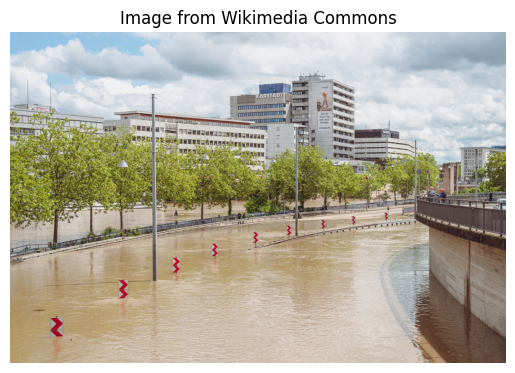

In [14]:
show_image_from_url(image_url)

(jupytergis)=

## Create JupyterGIS map
### Open Jupyter notebook

In [15]:
doc = GISDocument(jupytergis_filename, latitude=gps_lat, longitude=gps_lon, zoom=6,)

In [16]:
doc

(jupytergis-add-layer)=
### Add basemap layer

In [17]:
doc.add_raster_layer(
    url="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    name="Google Satellite",
    attribution="Google",
    opacity=0.6,
)

'f2b11634-5d1d-480b-9e36-aa7f6822ce3b'

In [18]:
doc.layers

{'f2b11634-5d1d-480b-9e36-aa7f6822ce3b': {'parameters': {'source': '24353959-b2c7-4d6c-9ecf-2cb08f71488e',
   'opacity': 0.6},
  'name': 'Google Satellite',
  'filters': None,
  'visible': True,
  'type': 'RasterLayer'}}

(jupytergis-add-layer)=

(jupytergis-add-layer)=
### Add HQ100 Flood Area Layer

In [19]:
doc.add_geojson_layer(path=filename_hq100, 
                      name="HQ100 generalized flood zones", 
                      color_expr={"fill-color": "#00f2ff", "stroke-width": 4.25, "stroke-color": "#0400ff", },
                     )

'4c5805af-8964-4a75-b2f4-48fa86180c63'

(jupytergis-add-layer)=
### Add the locations of companies at risk of flooding in Saarland.

In [20]:
doc.add_geojson_layer(path=filename_ied, 
                      name="Businesses at risk in Saarland", type='circle', 
                      color_expr={"circle-radius": 9, "circle-stroke-width": 4.25, 
                                  "circle-stroke-color": "#d400ff", "circle-fill-color": "#ffb700"},
                     )

'8b4bbe2e-cbcf-4a75-b183-662c60619355'

(jupytergis-add-layer)=
### Add location of the picture from Wikimedia Commons

In [21]:
doc.add_geojson_layer(path=wikimedia_artefact_location_filename, 
                      name='Artefact Location', type='circle', 
                      color_expr={"circle-radius": 10, "circle-stroke-width": 5.25, 
                                  "circle-stroke-color": "#ff3700", "circle-fill-color": "#fff700"})

'f2ca4008-3ec0-40c9-aac4-106c7b9e8580'